# Metric learning with siamese networks and triplets
### Learn 9d embeddings of colored images via siamese networks and online triplet mining

### 1. Import all necessary modules and data

In [2]:
import os
from gc import collect
from itertools import product
from PIL import Image

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, ElasticTransform,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, Cutout, RandomFog, 
    RandomRain, RandomSunFlare,VerticalFlip, Downscale, RandomShadow, CLAHE, RGBShift,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ToFloat, MultiplicativeNoise, JpegCompression
)

import cv2

import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform,he_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model,normalize
from tensorflow.keras.applications import MobileNetV2

from skimage.transform import resize
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.utils import shuffle

from tqdm import tqdm_notebook as tqdm
%matplotlib inline

np.random.seed(0)

# define input shape of images for training
img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 3)

# load dataset
file = 'dataset.dict'
dataset = joblib.load(file)

     |████████████████████████████████| 668 kB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# check number of classes 
nb_classes = len(dataset)
nb_classes

9

In [4]:
# check number of samples per class (color)
[dataset[i].shape[0] for i in range(nb_classes)]

[195, 250, 261, 215, 273, 205, 355, 227, 266]

### 2. Construct train and test splits

In [5]:
dataset_train = []
dataset_test = []
x_test_origin = []
y_test_origin = []
tmp = []
# dataset is slightly imbalanced, so we make some simple augmentations as flipping to make it balanced
max_count = max([dataset[i].shape[0] for i in range(nb_classes)])*19//20
# use tqdm for progress bar
for i in tqdm(range(9)):
    dataset_train.append(dataset[i][:dataset[i].shape[0]*19//20])
    for j, _ in enumerate(dataset_train[-1]):
        tmp.append(resize(dataset_train[-1][j][:,:,::-1], input_shape, 3, preserve_range=True))
    for j, _ in enumerate(dataset_train[-1]):
        # when count of images exceedes threshold, break
        if len(tmp) > max_count+13:
            break
        # flip images horizontaly
        tmp.append(resize(dataset_train[-1][j][:,::-1,::-1], input_shape, 3, preserve_range=True))
    dataset_train[-1] = np.array(tmp, dtype=np.uint8)
    # same for test set
    tmp=[]
    dataset_test.append(dataset[i][dataset[i].shape[0]*19//20:])
    for j, _ in enumerate(dataset_test[-1]):
        tmp.append(resize(dataset_test[-1][j][:,:,::-1], input_shape, 3, preserve_range=True))
        tmp.append(resize(dataset_test[-1][j][:,::-1,::-1], input_shape, 3, preserve_range=True))
    dataset_test[-1] = np.array(tmp, dtype=np.uint8)
    # make one test set array instead of list of arrays
    tmp=[]
    for x in dataset_test[i]: 
        x_test_origin.append(x)
        y_test_origin.append(i)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [6]:
# sanity check that all classes have same shape
[dataset_train[i].shape for i in range(nb_classes)]

[(350, 128, 128, 3),
 (350, 128, 128, 3),
 (350, 128, 128, 3),
 (350, 128, 128, 3),
 (350, 128, 128, 3),
 (350, 128, 128, 3),
 (350, 128, 128, 3),
 (350, 128, 128, 3),
 (350, 128, 128, 3)]

In [7]:
# shuffle test set and similtaneosly converting it to np.ndarray 
x_test_origin, y_test_origin =  shuffle(x_test_origin, y_test_origin)

### 3. Visualize some examples per each class

Checking shapes for class 0 (train) :  (350, 128, 128, 3)
Checking shapes for class 0 (test) :  (20, 128, 128, 3)
Checking first samples


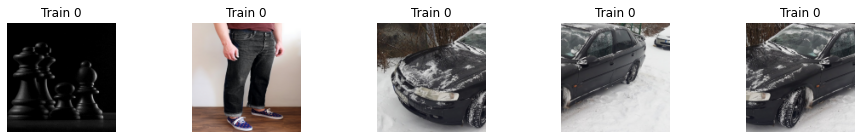

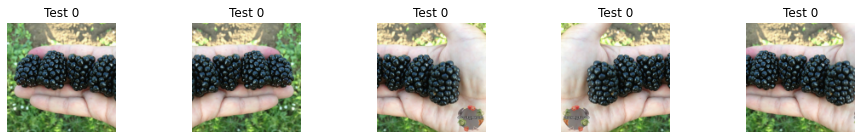

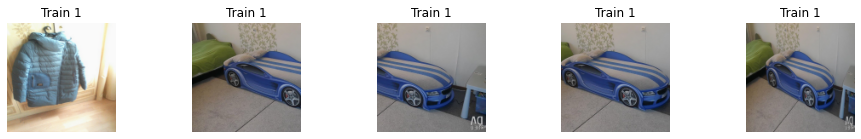

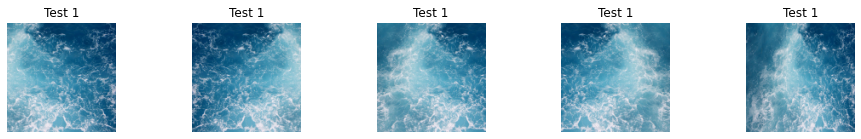

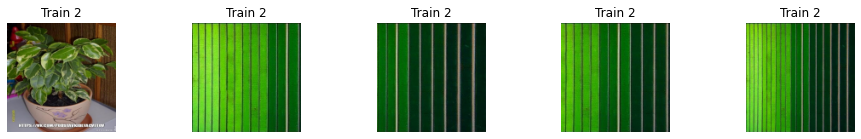

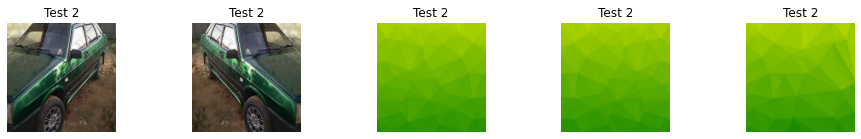

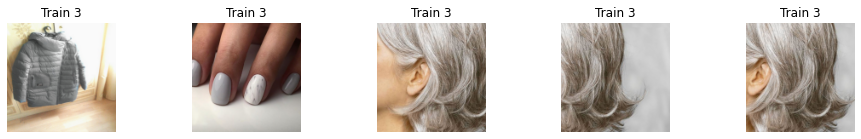

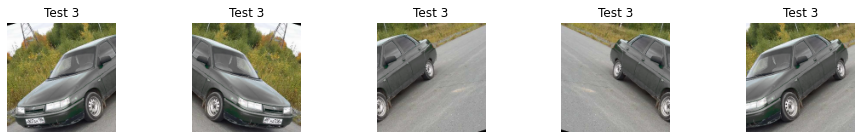

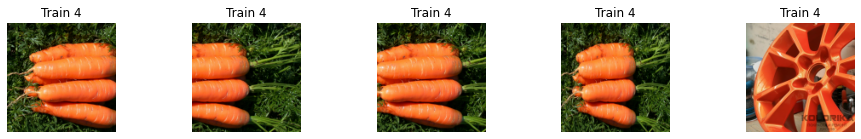

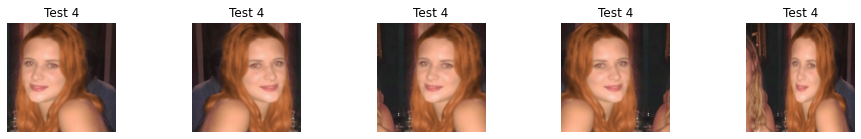

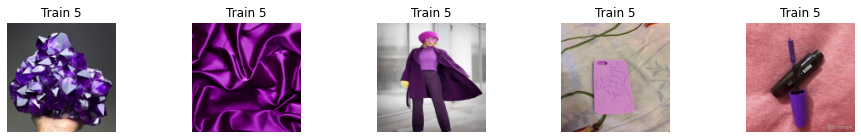

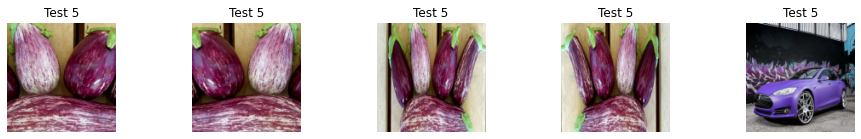

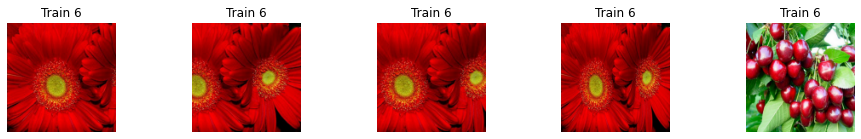

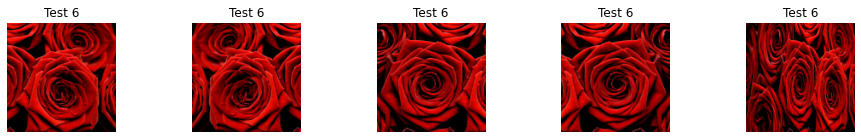

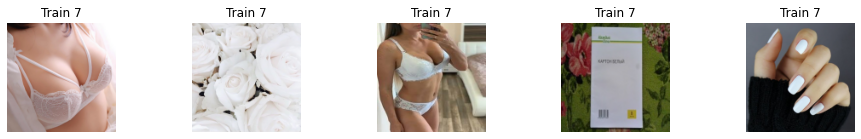

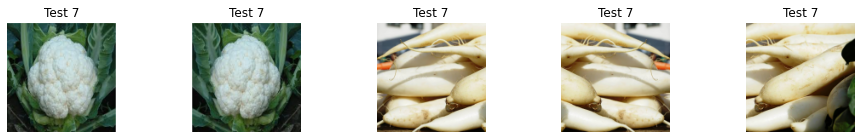

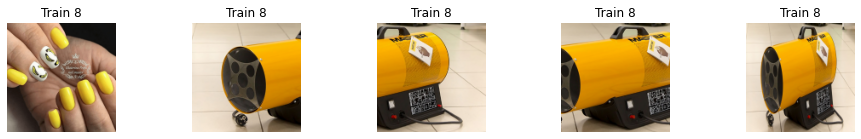

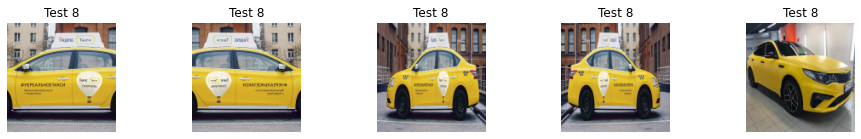

In [8]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis('off')
        if tensor.shape[-1] != 3:
            plt.imshow(tensor[m,:,:,0], vmin=0, vmax=1)
        else:
            plt.imshow(tensor[m,:,:,:], vmin=0, vmax=1)
        if (classnumber!=None):

            subplot.title.set_text((template.format(classnumber)))

print("Checking shapes for class 0 (train) : ",dataset_train[0].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[0].shape)
print("Checking first samples")
for i in range(nb_classes):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

### 4. Build base network and siamese network

In [9]:
def build_network_mobilenet(input_shape, embeddingsize):
    ''' Define the Keras Base Model for training
            Args: 
                input_shape (tuple): shape of input images.
                embeddingsize (int): size of embeddings.

            Returns:
                Keras Model.

    '''
    inputs = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    # add mobilenetv2 as core network
    outputs = MobileNetV2(include_top=False,
                          alpha=0.15, # define how much parameters from original will be used 
                          pooling='max',
                          weights=None)(x)
    outputs = Dropout(0.15)(outputs)
    # add last embedding layer
    outputs = Dense(embeddingsize, activation=None,
                   kernel_initializer='he_uniform')(outputs)
    outputs = Lambda(lambda x: K.l2_normalize(x, axis=-1))(outputs)
    return Model(inputs, outputs)
    # force the encoding to live on the d-dimentional hypershpere
    
    
class TripletLossLayer(Layer):
    '''Class implementing a layer, which output is loss on triplets.

    Attributes:
        alpha (int): minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha).
                
    '''
    def __init__(self, alpha, **kwargs):
        '''Constructor of TripletLossLayer class. In constructor you have to define a
        margin in loss.

            Args:
                alpha (int): minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha).

        '''
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        '''Computer triplet loss on three input layers.

            Args:
                inputs (list of tensorflow.Tensor): list of tensorflow.Tensors of shape.

            Returns:
                loss (tensorflow.Tensor): triplet loss value.

        '''
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        return K.sum(1. - K.sigmoid(p_dist - n_dist), axis=0)
    
    def call(self, inputs):
        '''Overwrites Layer's call method.

            Args:
                inputs (list of tensorflow.Tensor): list of tensorflow.Tensors of shape.

            Returns:
                loss (tensorflow.Tensor): triplet loss value.

        '''
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model(input_shape, network, margin=0.2):
    '''Define the Keras Model for training 
            Args: 
                input_shape : shape of input images
                network : Neural network to train outputing embeddings
                margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
            Returns:
                Siamese NN with TripletLossLayer
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input') 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

# define size of embeddings
embeddingsize = nb_classes
# build core network
network = build_network_mobilenet(input_shape, embeddingsize=embeddingsize)
# build siamese tripletloss network
network_train = build_model(input_shape,network, margin=0.3)
# compile optimizers
optimizer = tf.keras.optimizers.RMSprop(lr = 0.001, momentum=0.5)
network_train.compile(loss=None, optimizer=optimizer)
network_train.summary()
# plot architectures
plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='02 model.png')
plot_model(network,show_shapes=True, show_layer_names=True, to_file='01 model.png')
n_iteration=0


def drawTriplets(tripletbatch, nbmax=None):
    '''Display the three images for each triplets in the batch
       Args:
            tripletbatch (list of numpy.ndarray): batch with triplets.
            nbmax (int): maximum number of plotted triplets.

       Returns:
            None.

    '''
    labels = ['Anchor', 'Positive', 'Negative']

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax, tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis('off')
            if tripletbatch[i].shape[-1] == 3:
                plt.imshow(tripletbatch[i][row,:,:,:], vmin=0, vmax=1)
            else:
                plt.imshow(tripletbatch[i][row,:,:,0], vmin=0, vmax=1)
            subplot.title.set_text(labels[i])
            
            
def compute_dist(a, b):
    '''Compute l2 distances between embeddings.
        Args:
            a (numpy.ndarray): first embedding of shape (n,).
            b (numpy.ndarray): second embeddings of shape (n,). 

        Returns:
            distance (float): l2 distance.

    '''
    return np.sum(np.square(a-b))

def compute_probs(network, X, Y):
    '''Compute probabilities of being the right decision
        Args:
            network : current NN to compute embeddings.
            X (numpy.ndarray): tensor of shape (m,w,h,1) containing pics to evaluate.
            Y (numpy.ndarray): tensor of shape (m,) containing true class.

        Returns:
            probs : array of shape (m,m) containing distances.
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : 
                # it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y

def compute_metrics(probs,yprobs):
    '''Compute ROC-AUC score
        Args:
            probs : computed probabilities of class being the right decision.
            yprobs : true values of classes for probabilities.

        Returns:
            fpr : Increasing false positive rates such that element i is the false positive
                rate of predictions with score >= thresholds[i].
            tpr : Increasing true positive rates such that element i is the true positive
                rate of predictions with score >= thresholds[i].
            thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr.
                thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.
            auc : Area Under the ROC Curve metric.

    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings

        Args:
            network: Neural network to train outputing embeddings

        Returns:
            array of shape (nb_classes, nb_classes)

    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,*input_shape))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    '''Plots interdistance between classes on n_iteration: 
        A good model should have a large distance between all theses embeddings

        Args:
            network: Neural network to train outputing embeddings.
            n_iteration: Current number of iterations.

        Returns:
            None.

    '''
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    '''Find nearest array element to given value.
            Args:
                array: Array with shape (m, n) or (n, m).
                value: Value with shape (1, n) or (n,).

            Returns:
                array_element with shape (1, n) or (n,).

    '''
    idx = np.searchsorted(array, value, side='left')
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr, thresholds, auc):
    '''Plot ROC-AUC curve.
    
            Args:
                fpr: false positive rates.
                tpr: true positive rates.
                thresholds: thresholds for auc.
                auc: auc score

            Returns:
                None.

    '''
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

def plot_history(history):
    '''Plots and save loss curve figure during training.
            Args:
                history (numpy.ndarray): history of shape (N, 3), where 3 corresponds to
                    mean_loss, 2.5% loss percentile and 97.5% loss percentile per interval.
                    Thus, in the resulting curve we can see loss curve and it's 95% CI.
                
            Returns:
                None.

    '''
    plt.figure(figsize=(20, 20))
    plt.xticks(rotation=45)
    loss_curve = np.array(history)[:, 0] / np.array(history)[:, 0].max() # normalize
    plt.plot(loss_curve)
    plt.fill_between(np.arange(len(history)),
                     np.array(history)[:, 1] / np.array(history)[:, 0].max(),
                     np.array(history)[:, 2] / np.array(history)[:, 0].max(),
                     alpha=0.2)
    plt.savefig('training_curve.png')
    # backup results, so we have access to history after restart
    joblib.dump(history, 'history.gz', 3, 4)
    plt.show()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 9)            154745      anchor_input[0][0]               
                                                                 positive_input[0][0]  

### 5. Construct augmentation instance 

In [10]:
def strong_aug(p=0.5, colors='grayscale', holes=[1, 5, 15, 30], sizes=[5, 3, 2, 1]):
    '''Constructs augmentor for images with given probability p.
    
            Args:
                p (float): probability in [0, 1), that image will be augmented.
                    Higher values corresponds to heavier augmentations.
                colors (str, default is 'grayscale'): if not default then CoarseDropout 
                    will include all basic colors and shades (3**3 or 27).
                holes (list of ints, default is [1, 5, 15, 30]): list of number of different holes 
                    number in CoarseDropout.
                sizes (list of ints, default is [5, 3, 2, 1]): list of sizes of different holes
                    in CoarseDropout. 

            Returns:
                albumentations.augmentations.Compose.

    '''
    # add one of basic image quality reduction augmentations
    image_quality = OneOf([OneOf([MotionBlur(blur_limit=(3, 3), p=0.1),
                                   MedianBlur(blur_limit=(3, 3), p=0.1),
                                   Blur(blur_limit=(3, 3), p=0.15),
                                   JpegCompression(quality_lower=30, quality_upper=80, p=0.1),
                                   Downscale(p=0.2, scale_min=0.5, scale_max=0.5)],
                                  p=0.2)],
                            p=0.1)
    
    # add one of basic image noise applying augmentations
    image_noise = OneOf([GaussNoise(p=0.2, var_limit=(0.0001, 0.001)),
                         IAASharpen(p=0.2),
                         IAAEmboss(p=0.1)],
                        p=0.4)
    
    # add Sparse Dropout
    if colors=='grayscale':
        image_sparse_dropout = OneOf([OneOf([Cutout(num_holes=holes, max_h_size=size, 
                                                    max_w_size=size, fill_value=fill_value, 
                                                    p=0.2) for holes, size in zip(holes, sizes)],
                                            p=1.0) for fill_value in product([0.0, 0.5, 1.0], repeat=1)],
                                     p=0.5)
    else:
        image_sparse_dropout = OneOf([OneOf([Cutout(num_holes=holes, max_h_size=size, 
                                                    max_w_size=size, fill_value=fill_value, 
                                                    p=0.2) for holes, size in zip(holes, sizes)],
                                            p=1.0) for fill_value in product([0.0, 0.5, 1.0], repeat=3)],
                                     p=0.5)

    return Compose([
                    # convert to float, so augmentations will use only float implementations
                    # prevents unexpected behavior
                    ToFloat(max_value=1.0),

                    image_quality,

                    image_noise,

                    # add linear transformations
                    HorizontalFlip(p=0.6),
                    VerticalFlip(p=0.5),
                    ShiftScaleRotate(rotate_limit=45, shift_limit=0.0525, 
                                     scale_limit=(-0.15, 0.3), p=0.4),

                    image_sparse_dropout,
                    ], p=p)

augmentation = strong_aug(0.9, colors='full')

### 6. Construct update-dataset function

In [11]:
def change_hue(img, value):
    '''Changes saturation of an image multiple time of given value.
            Args:
                img (numpy.ndarray): image of shape (width, height, 3).
                value (float): saturation fraction (0. - black/white image,
                                                1. - unmodified,
                                                >1. - oversaturated image,
                                                0..1 - something in-between)

            Returns:
                image (numpy.ndarray): processed image.

    '''
    imghsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_value, s_value, v_value = cv2.split(imghsv)
    s_value *= value
    s_value = np.clip(s_value, 0.0, 1.0)
    imghsv = cv2.merge([h_value, s_value, v_value])
    return np.clip(cv2.cvtColor(imghsv, cv2.COLOR_HSV2BGR), 0.0, 1.0)
    imghsv = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(imghsv)
    s *= value
    s = np.clip(s, 0.0, 1.0)
    imghsv = cv2.merge([h, s, v])
    return np.clip(cv2.cvtColor(imghsv, cv2.COLOR_HSV2BGR), 0.0, 1.0)
    

def update_aug(X, augmentor, verbose=False):
    '''Constructs augmented dataset by given original dataset and augmentor.
            Args:
                X (list of numpy.ndarrays): Input dataset of uint8 dtype.
                augmentor (albumentations.augmentations.Compose instance): Augmentor to use.
                verbose (bool, default=False): If True, then progress bar will be shown.
                
            Returns:
                dataset_aug (numpy.ndarray): augmented dataset of uint8 dtype 
                    with shape (number of classes, max examples per class, height, width, channels).

    '''
    dataset_aug = []
    # call garbage collector
    for i in range(15): 
        time.sleep(0.1)
        collect()
    # repetitions define how many augmented instances of same image 
    # would be in the resulting dataset
    iterator = tqdm(range(nb_classes)) if verbose else range(nb_classes)
    repetitions = 3
    for i in iterator:
        # low-saturated images will help to train a more robust network 
        saturations = np.random.uniform(0.5, 1.25, size=(repetitions, X[i].shape[0]))
        
        dataset_aug.append(np.concatenate([np.uint8([change_hue(augmentor(image=im/255.)['image'], 
                                                                s)*255 for s, im in zip(saturations[k], X[i])])
                for k in range(repetitions)]))
    return dataset_aug

dataset_aug = np.array(update_aug(dataset_train, augmentation, verbose=True))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,


### 7. Check random image in augmentated dataset

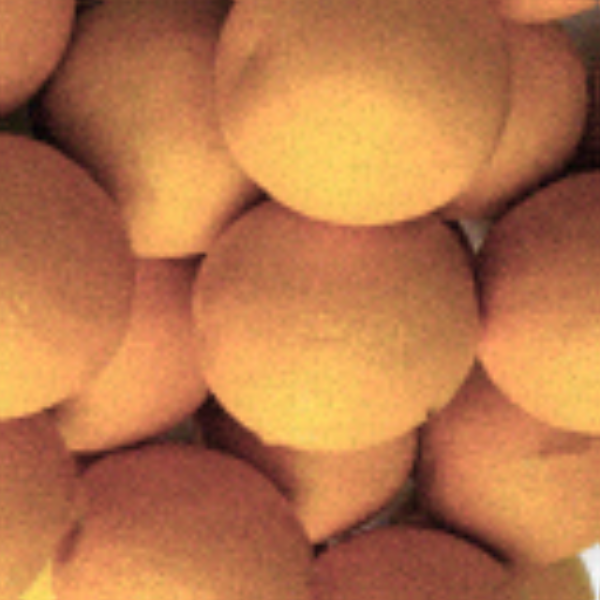

In [13]:
Image.fromarray(resize((dataset_aug[4][-125]).astype(np.uint8), 
                       (600, 600, 3), 
                       preserve_range=True).astype(np.uint8))

### 8. Define our online triplet-mining functions: random picking and with the help of neural network.

In [14]:
def get_batch_random(batch_size, s='train', return_indexes=False):
    '''Create batch of APN triplets with a complete random strategy

            Args:
                batch_size (integer)
                s (str, default is 'train'): if s equals 'train' then use 'dataset_train' global variable;
                    if s equals 'train_aug' then use 'dataset_aug' global variable;
                    else use 'dataset_test' global variable.
                return_indexes (bool, default is False): if True then instead of triplets with images will return
                triplets with corresponding indexes of that images in dataset.
                
            Returns:
                triplets (list): list containing 3 tensors A,P,N of shape (batch_size, w, h, c).

    '''
    if s == 'train':
        X = dataset_train
    elif s == 'train_aug':
        X = dataset_aug
    else:
        X = dataset_test
    # in current optimised version of function imbalanced datasets are not supported
    assert isinstance(X, np.ndarray), 'Dataset for metric learning must be ' \
                                      'ndarray of shape (nb_classes, same_examples, width, height, channels)!' \
                                      '\nInstead got: {}'.format(type(X))

    nb_classes = len(X)
    repetitions, w, h, c = X.shape[-4:]
    # initialize result
    a_classes = np.random.randint(0, nb_classes, size=batch_size)
    n_offsets = np.random.randint(1, nb_classes, size=batch_size)
    # pick another class for N, different from anchor_class
    n_classes = (a_classes + n_offsets) % nb_classes
    # pick two different random pics for this class => A and P
    idx_A = np.random.randint(repetitions, size=(batch_size))
    idx_P = (idx_A + np.random.randint(1, repetitions, size=(batch_size))) % repetitions
    # Pick a random pic for this negative class => N
    idx_N = np.random.randint(repetitions, size=(batch_size))

    if return_indexes:
        return a_classes, n_classes, idx_A, idx_P, idx_N
    return X[a_classes, idx_A].copy(), X[a_classes, idx_P].copy(), X[n_classes, idx_N].copy()

In [16]:
def get_batch_hard(draw_batch_size, hard_batchs_size, norm_batchs_size, s='train'):
    '''Create batch of APN "hard" triplets
    
            Arguments:
                draw_batch_size (integer): number of initial randomly taken samples.
                hard_batchs_size (interger): select the number of hardest samples to keep.
                norm_batchs_size (interger): number of random samples to add.

            Returns:
                triplets (list): list containing 3 tensors A,P,N of shape 
                    (hard_batch_size+norm_batch_size, w, h, c).

    '''
    if s == 'train':
        X = dataset_train
    elif s == 'train_aug':
        X = dataset_aug
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    # Step 1 : pick a random batch to study
    a_classes, n_classes, idx_A, idx_P, idx_N = get_batch_random(draw_batch_size,
                                                                 s, return_indexes=True)
    studybatch = X[a_classes, idx_A].copy(), X[a_classes, idx_P].copy(), X[n_classes, idx_N].copy()
    # Step 2 : compute the loss with current network : d(A,P)-d(A,N). 
    # The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    # Compute embeddings for anchors, positive and negatives
    
    A = metrics[a_classes, idx_A].copy()#O[:draw_batch_size].copy()
    P = metrics[a_classes, idx_P].copy()#O[draw_batch_size:draw_batch_size*2].copy()
    N = metrics[n_classes, idx_N].copy()#O[draw_batch_size*2:].copy()
    
    
    # Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    # Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[-(hard_batchs_size+64):-64]
    
    # Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection], studybatch[1][selection], studybatch[2][selection]]
    
    return triplets

### 9. Augment test dataset so it will have more diversity

In [21]:
x_test_origin_new = []
y_test_origin = np.array(y_test_origin).repeat(2)
for i in range(len(x_test_origin)):
    x_test_origin_new.append(x_test_origin[i])
    x_test_origin_new.append(change_hue(augmentation(image=x_test_origin[i]/255.)["image"], 
                                        np.random.uniform(0.5, 1.3))*255)

x_test_origin = np.uint8(x_test_origin_new)
x_test_origin.shape, y_test_origin.shape

((468, 128, 128, 3), (468,))

### 10. Train siamese network

Starting training process!


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,


-------------------------------------
[array([160., 100., 300.]), array([53.29227792, 36.72723837, 75.78411179]), array([28.389473  , 17.71396041, 41.95924263]), array([33.65139003,  1.10595816, 85.39797897]), array([28.52816327,  0.13042798, 80.46666832]), array([ 51.71237833,  25.49133382, 116.31080284]), array([ 7.81441987,  0.        , 34.11224222]), array([ 26.16679836,   0.        , 118.1076561 ]), array([ 18.48313239,   0.        , 112.31786404]), array([ 70.41351279,  35.72972612, 145.51825829]), array([43.56429871, 12.38870723, 75.01701813]), array([3.54147821e+01, 4.96635064e-03, 9.35975649e+01]), array([11.55985085,  0.        , 53.88497753]), array([ 25.35504418,   0.        , 110.46296577]), array([ 14.88861717,   0.        , 106.66929245]), array([ 38.56957531,   0.        , 159.57199287]), array([ 28.90898389,   0.        , 154.3924015 ]), array([ 35.59462335,   0.        , 141.02921448]), array([ 25.67521775,   0.        , 146.93845444]), array([18.79030974,  8.74497533

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



 ------------- 

[46000] Time for 46000 iterations: 17.283333333333335 mins, Train Loss: (5.2906083634069985, 0.0, 27.51405811309814)


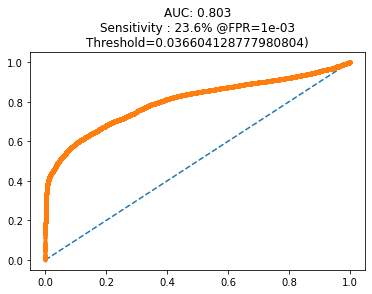

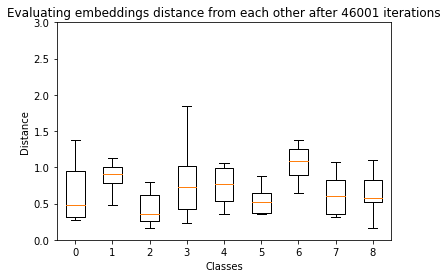

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 19, 28, 45), server_modified=datetime.datetime(2020, 8, 25, 19, 28, 45), rev='015adb8b6337a4900000001b45de3f0', size=65551, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='2912e90209ec77a38a297579883037498cf33a4e1e002d1af581d649c9f2f41f', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 19, 28, 47), server_modified=datetime.datetime(2020, 8, 25, 19, 28, 47), rev='015adb8b649d92c00000001b45de3f0', size=789, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_inf

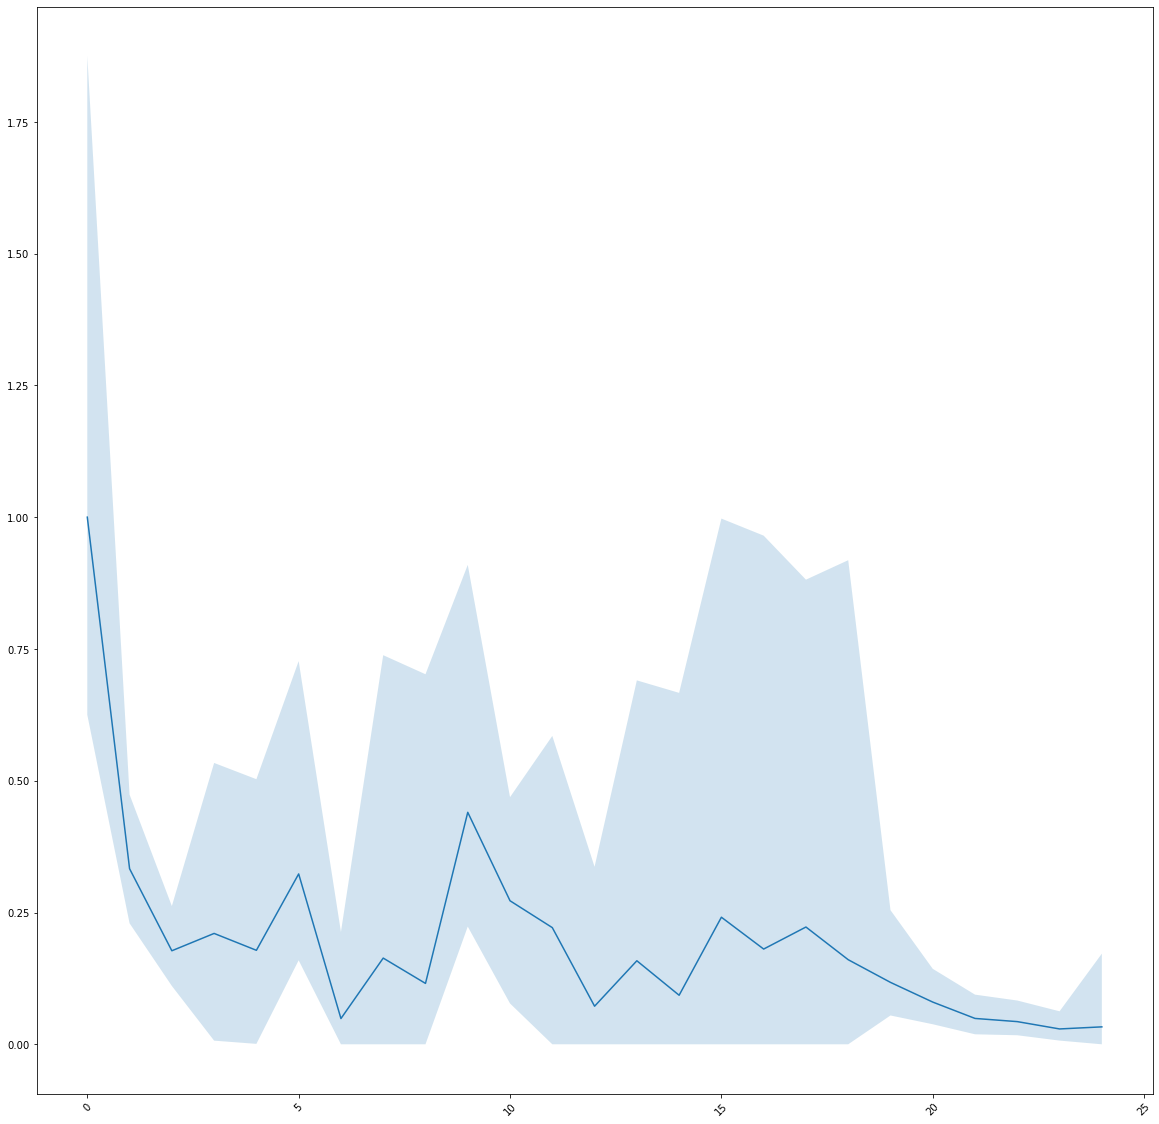

FileMetadata(name='colors_mobilenet_aug_best.h5', id='id:5mmeH8mJUyAAAAAAAAAChQ', client_modified=datetime.datetime(2020, 8, 25, 19, 28, 49), server_modified=datetime.datetime(2020, 8, 25, 19, 28, 49), rev='015adb8b66bed0800000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_best.h5', path_display='/colors_mobilenet_aug_best.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='7cbd63376663be7dd8d28eaeb17231c8fd73d69a14198311362111b047d62872', file_lock_info=None)
FileMetadata(name='colors_mobilenet_aug_2.h5', id='id:5mmeH8mJUyAAAAAAAAACiA', client_modified=datetime.datetime(2020, 8, 25, 19, 28, 51), server_modified=datetime.datetime(2020, 8, 25, 19, 28, 51), rev='015adb8b687c4eb00000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_2.h5', path_display='/colors_mobilenet_aug_2.h5', parent_shared_folder_id=None, media_in

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,



 ------------- 

[46500] Time for 46500 iterations: 41.56666666666667 mins, Train Loss: (7.482158750660718, 0.0, 61.202496051788316)


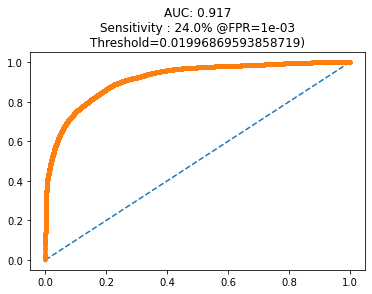

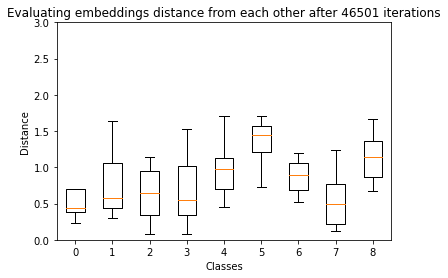

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 19, 53, 3), server_modified=datetime.datetime(2020, 8, 25, 19, 53, 3), rev='015adb90d0dd5fd00000001b45de3f0', size=65506, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='7f761d39256bd23ee8744d076d5a331a1f111836ef8c78c8207191fd0e03d185', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 19, 53, 4), server_modified=datetime.datetime(2020, 8, 25, 19, 53, 4), rev='015adb90d205ac500000001b45de3f0', size=809, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=No

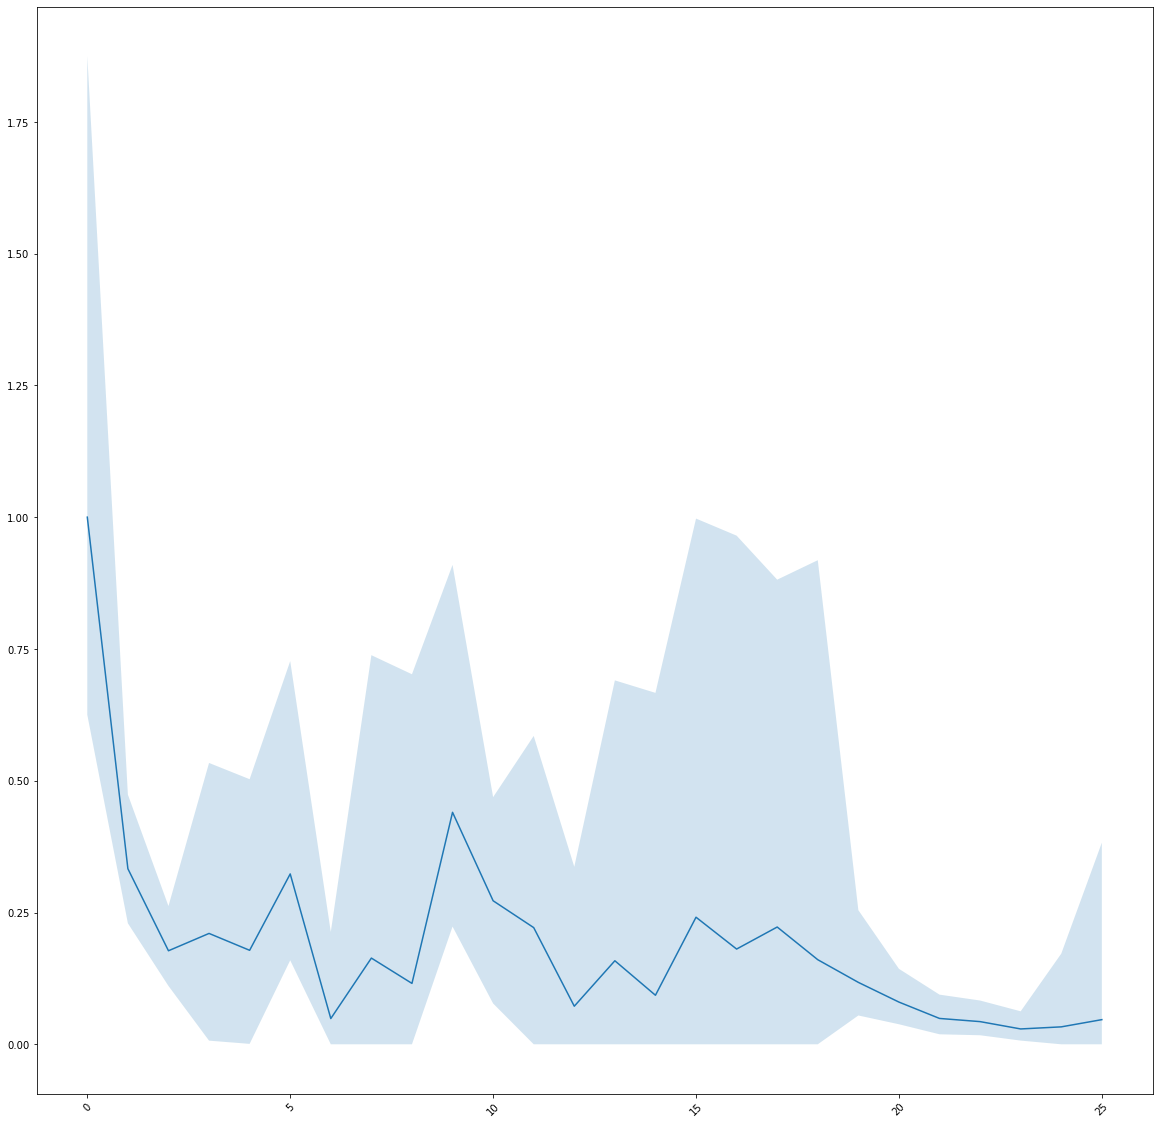

FileMetadata(name='colors_mobilenet_aug_3.h5', id='id:5mmeH8mJUyAAAAAAAAACiQ', client_modified=datetime.datetime(2020, 8, 25, 19, 53, 6), server_modified=datetime.datetime(2020, 8, 25, 19, 53, 6), rev='015adb90d478b7700000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_3.h5', path_display='/colors_mobilenet_aug_3.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='966d5eeec48440a6353e00c54e8221ddf8662f5f6b85ed625ca9257e3389d4da', file_lock_info=None)


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,



 ------------- 

[47000] Time for 47000 iterations: 65.76666666666667 mins, Train Loss: (22.961460244506597, 0.0, 134.5877490997314)


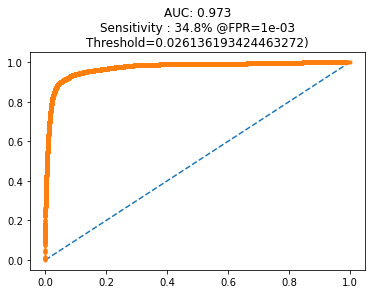

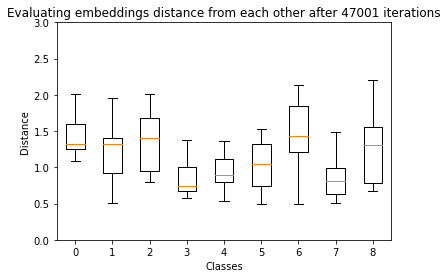

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 20, 17, 14), server_modified=datetime.datetime(2020, 8, 25, 20, 17, 14), rev='015adb96392f1b000000001b45de3f0', size=65493, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='ba1bb020cb83713ceaffe5cbd35f367fa1a24f36f225c881dac73c35487be029', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 20, 17, 16), server_modified=datetime.datetime(2020, 8, 25, 20, 17, 16), rev='015adb963abb2c500000001b45de3f0', size=827, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_inf

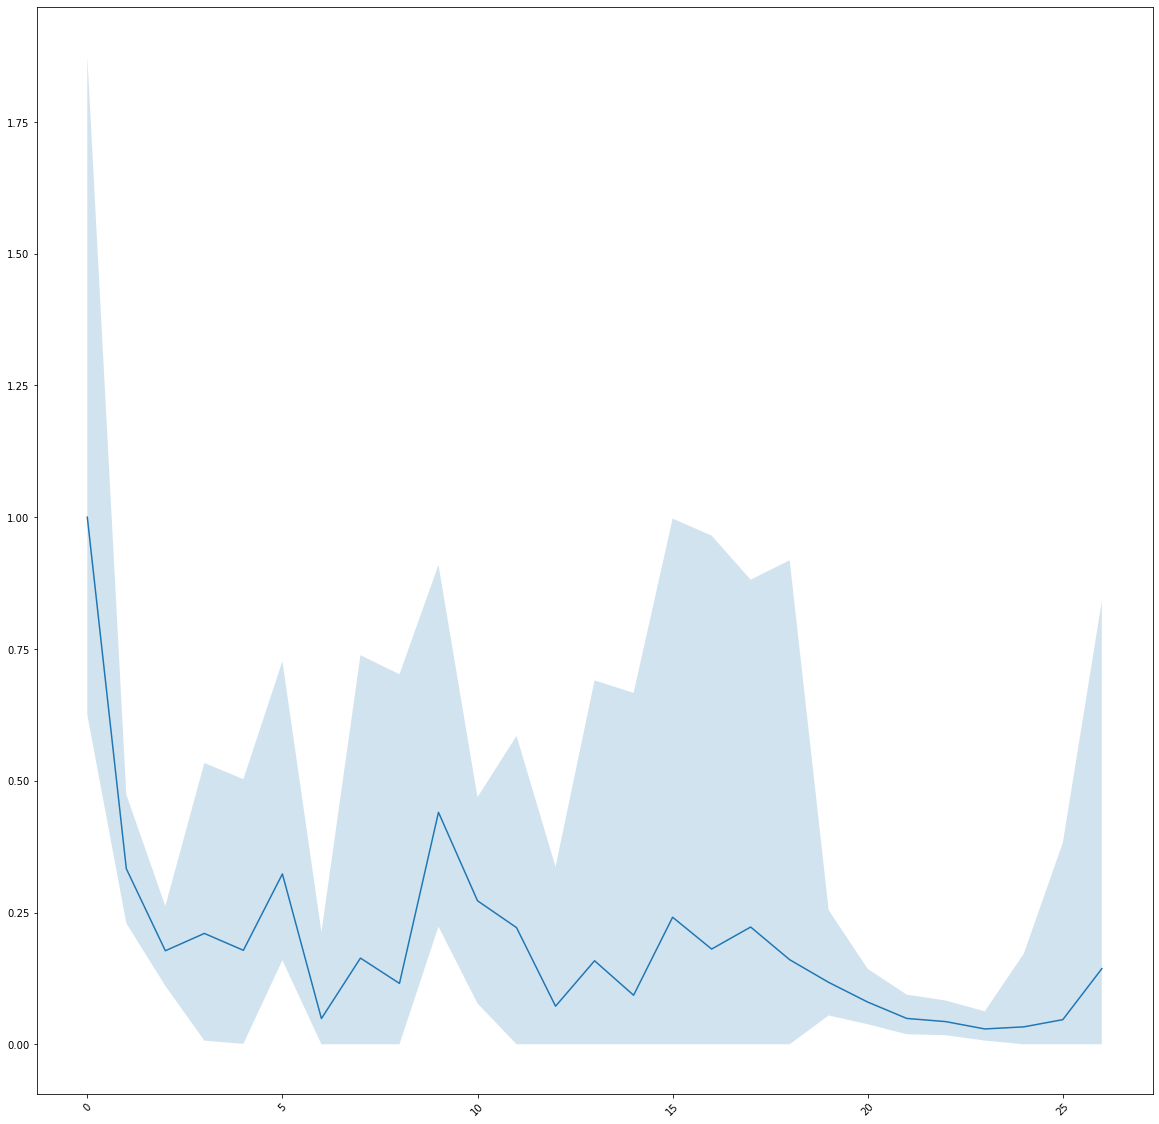

FileMetadata(name='colors_mobilenet_aug_4.h5', id='id:5mmeH8mJUyAAAAAAAAACig', client_modified=datetime.datetime(2020, 8, 25, 20, 17, 18), server_modified=datetime.datetime(2020, 8, 25, 20, 17, 18), rev='015adb963cbbf7200000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_4.h5', path_display='/colors_mobilenet_aug_4.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='5af58417d9441b163a34d92d50227a7e921bb1e51750f0f41aaba5fb666f258d', file_lock_info=None)


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,



 ------------- 

[47500] Time for 47500 iterations: 89.71666666666667 mins, Train Loss: (18.637964067548513, 0.0, 100.65754890441889)


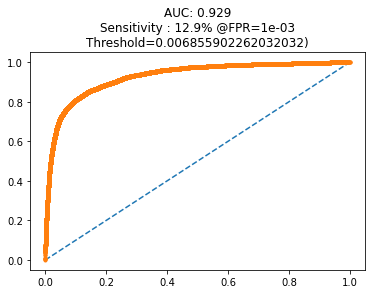

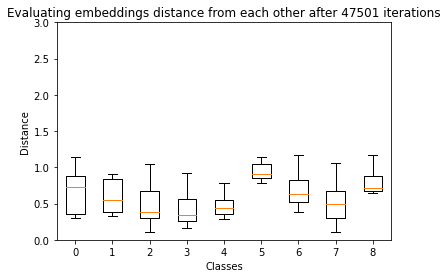

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 20, 41, 11), server_modified=datetime.datetime(2020, 8, 25, 20, 41, 11), rev='015adb9b935a69e00000001b45de3f0', size=66614, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='b66b58e52cc9bc61ecd36056a4bcd0dd9b4148ec309e37e89eddc30871ef2d3c', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 20, 41, 12), server_modified=datetime.datetime(2020, 8, 25, 20, 41, 12), rev='015adb9b948889800000001b45de3f0', size=847, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_inf

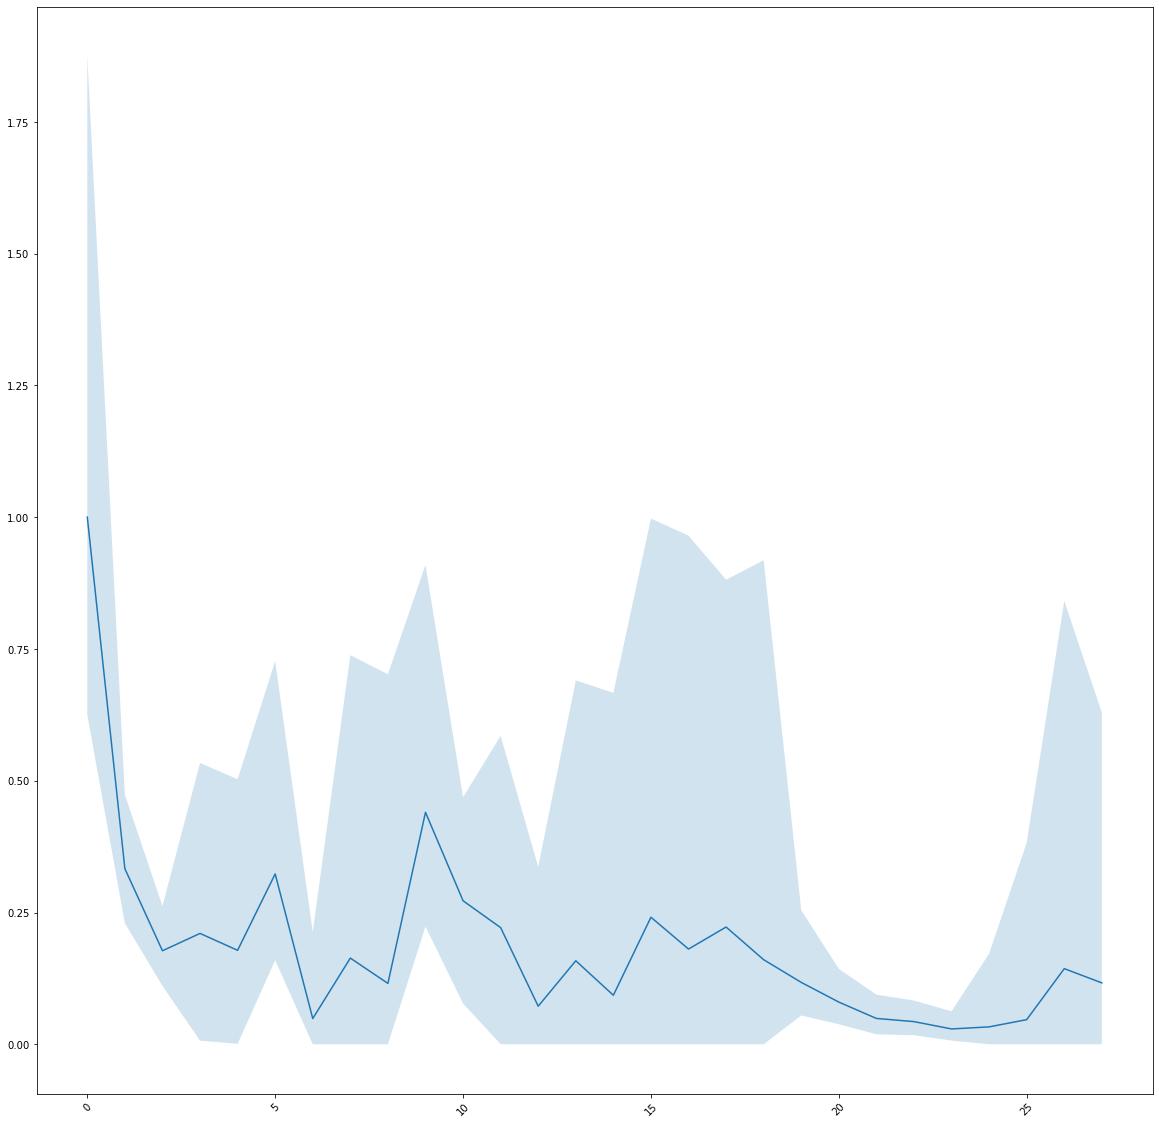

FileMetadata(name='colors_mobilenet_aug_5.h5', id='id:5mmeH8mJUyAAAAAAAAACiw', client_modified=datetime.datetime(2020, 8, 25, 20, 41, 14), server_modified=datetime.datetime(2020, 8, 25, 20, 41, 14), rev='015adb9b96b4d6300000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_5.h5', path_display='/colors_mobilenet_aug_5.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='96b0ebbd3b800a75a7a80082903d6ed710e22c5b3b1a40aebb339a339598a53d', file_lock_info=None)


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,



 ------------- 

[48000] Time for 48000 iterations: 113.6 mins, Train Loss: (4.459473174512386, 0.0, 53.78192863464348)


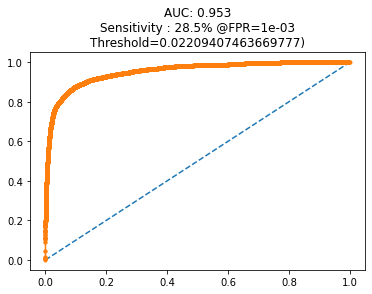

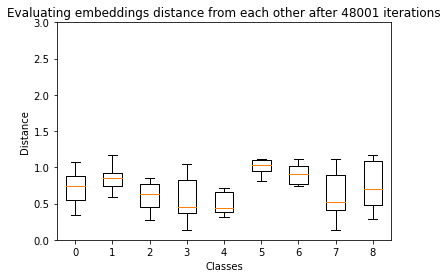

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 21, 5, 4), server_modified=datetime.datetime(2020, 8, 25, 21, 5, 4), rev='015adba0ea077fd00000001b45de3f0', size=67114, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='ac44b7d5ead08122e1645592ad944973d33d8fee6939f3bab0360b8508e38011', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 21, 5, 5), server_modified=datetime.datetime(2020, 8, 25, 21, 5, 5), rev='015adba0eb3cd6c00000001b45de3f0', size=866, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, 

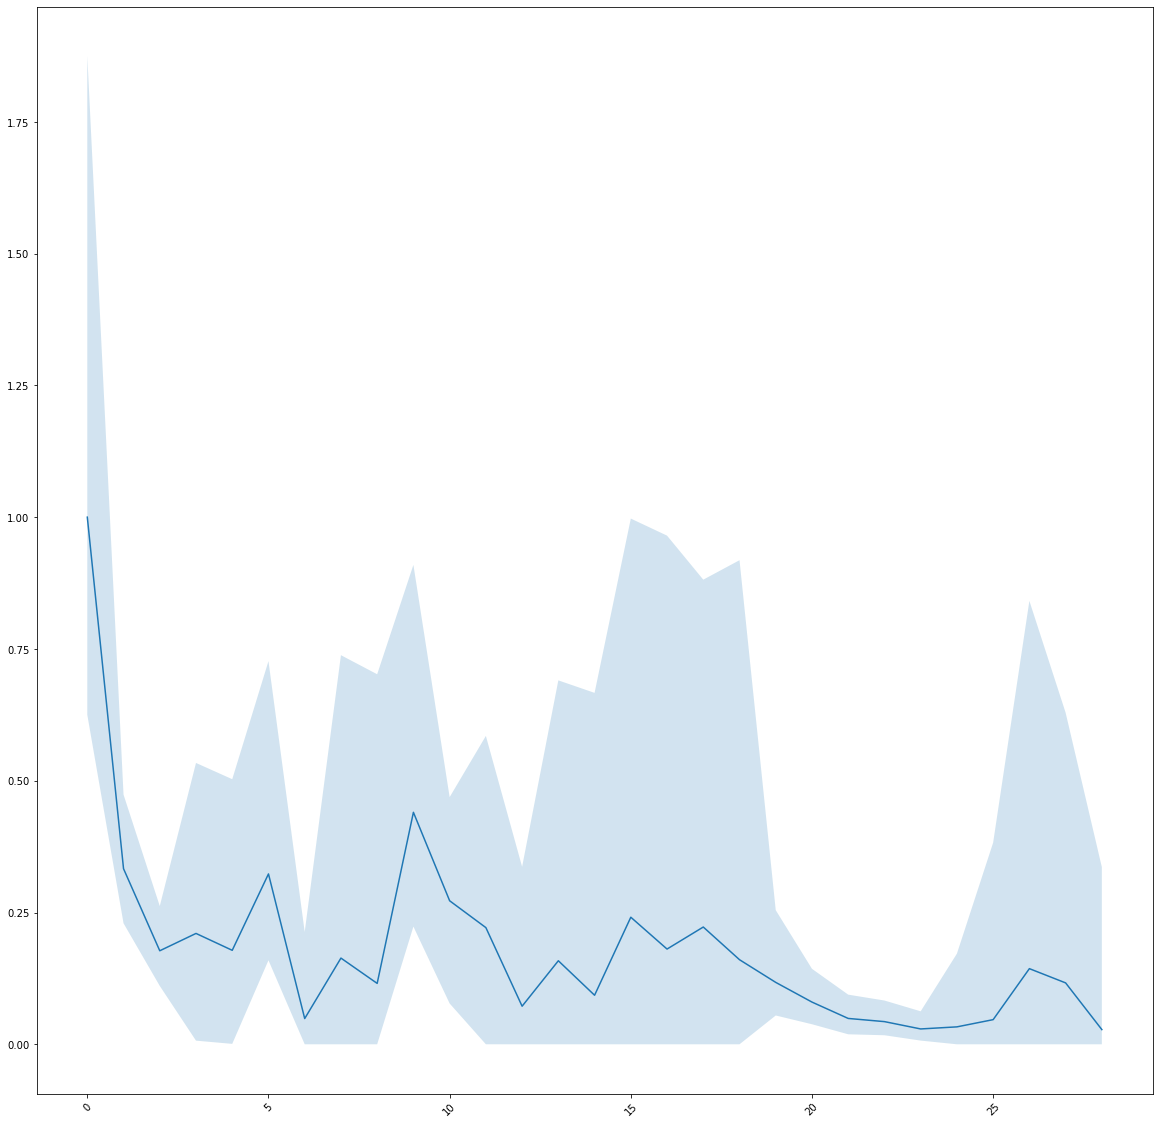

FileMetadata(name='colors_mobilenet_aug_best.h5', id='id:5mmeH8mJUyAAAAAAAAAChQ', client_modified=datetime.datetime(2020, 8, 25, 21, 5, 7), server_modified=datetime.datetime(2020, 8, 25, 21, 5, 7), rev='015adba0ed345d200000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_best.h5', path_display='/colors_mobilenet_aug_best.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='9fad818e88ee9ba76cb97b4a32803c5bebfcbfc3b0a3f0aaa4a5e867075506bd', file_lock_info=None)
FileMetadata(name='colors_mobilenet_aug_6.h5', id='id:5mmeH8mJUyAAAAAAAAACjA', client_modified=datetime.datetime(2020, 8, 25, 21, 5, 9), server_modified=datetime.datetime(2020, 8, 25, 21, 5, 9), rev='015adba0ef1479d00000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_6.h5', path_display='/colors_mobilenet_aug_6.h5', parent_shared_folder_id=None, media_info=None,

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,



 ------------- 

[48500] Time for 48500 iterations: 137.38333333333333 mins, Train Loss: (26.776091042287646, 0.0, 139.89868621826167)


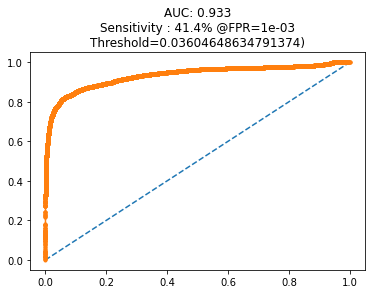

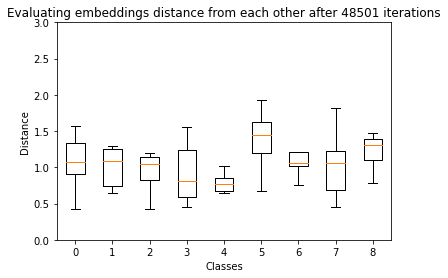

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 21, 28, 51), server_modified=datetime.datetime(2020, 8, 25, 21, 28, 51), rev='015adba63b5e57100000001b45de3f0', size=68705, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='f59113a6ce35c09b2d65309e97f8c651f1beb02d04df6390b929776fc840f61d', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 21, 28, 53), server_modified=datetime.datetime(2020, 8, 25, 21, 28, 53), rev='015adba63d112e100000001b45de3f0', size=886, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_inf

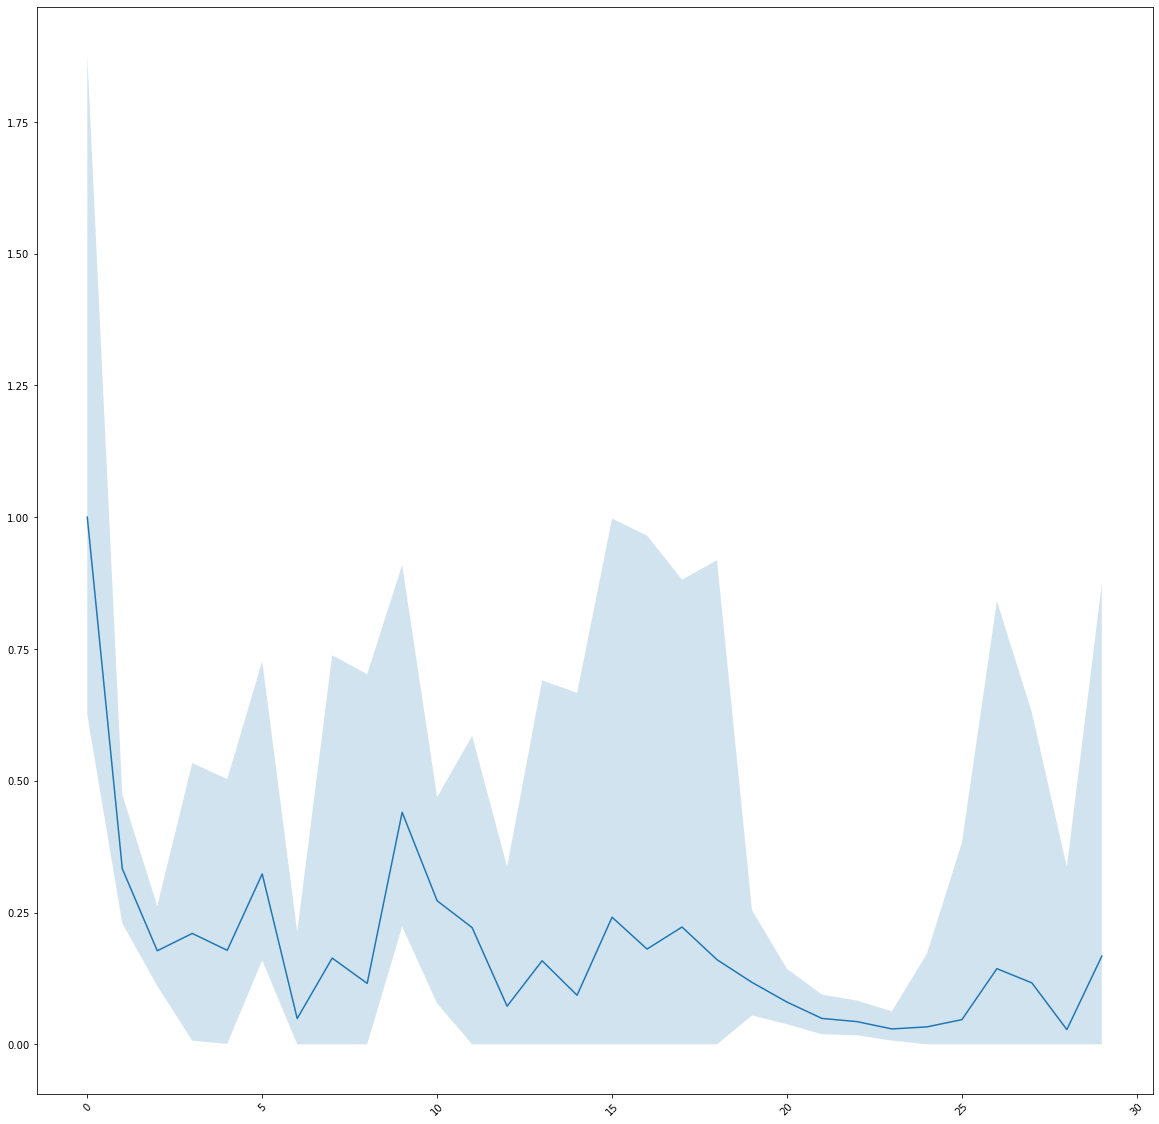

FileMetadata(name='colors_mobilenet_aug_7.h5', id='id:5mmeH8mJUyAAAAAAAAACjQ', client_modified=datetime.datetime(2020, 8, 25, 21, 28, 55), server_modified=datetime.datetime(2020, 8, 25, 21, 28, 55), rev='015adba63f1ac3900000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_7.h5', path_display='/colors_mobilenet_aug_7.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='c79675b0d6549455b990232eaa031ec235acf87936d29de1dedc4ca7d462911d', file_lock_info=None)


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,



 ------------- 

[49000] Time for 49000 iterations: 161.11666666666667 mins, Train Loss: (6.872399449706077, 0.0, 71.89891700744627)


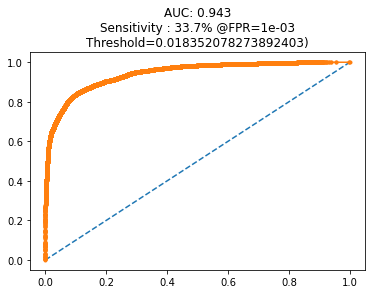

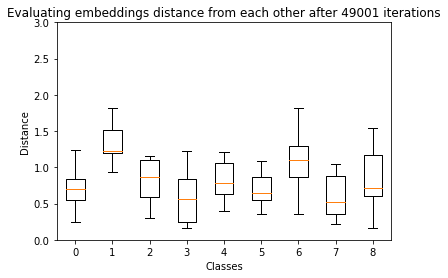

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 21, 52, 35), server_modified=datetime.datetime(2020, 8, 25, 21, 52, 35), rev='015adbab88eb16d00000001b45de3f0', size=69937, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='041ea8118fe22e28c17bb6fe2d5dff87b070ead793ad89132367c5992164f8d6', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 21, 52, 36), server_modified=datetime.datetime(2020, 8, 25, 21, 52, 36), rev='015adbab8a38f7d00000001b45de3f0', size=900, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_inf

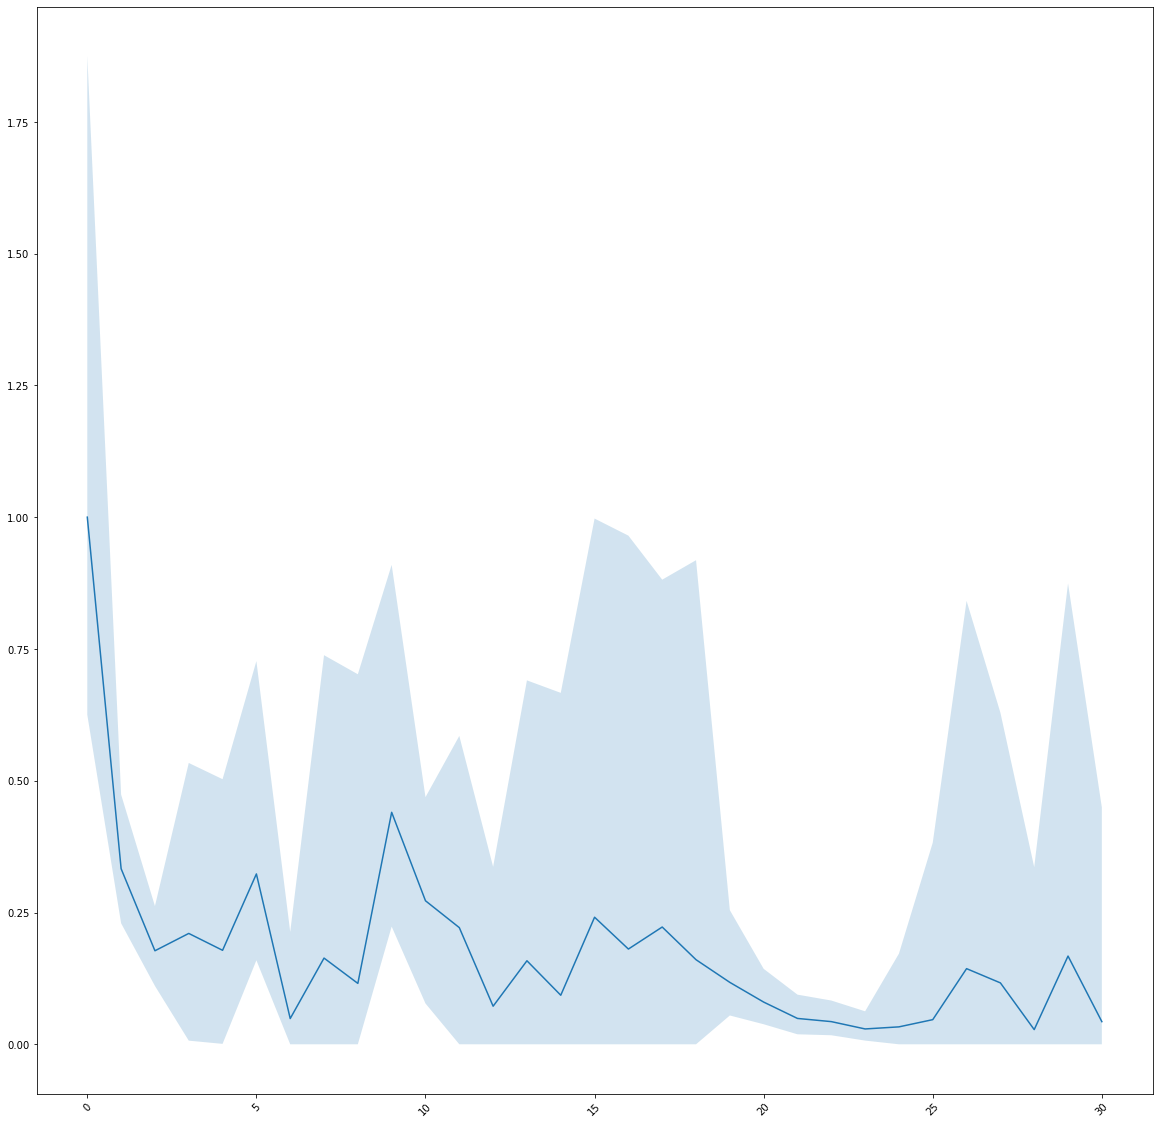

FileMetadata(name='colors_mobilenet_aug_8.h5', id='id:5mmeH8mJUyAAAAAAAAACjg', client_modified=datetime.datetime(2020, 8, 25, 21, 52, 38), server_modified=datetime.datetime(2020, 8, 25, 21, 52, 39), rev='015adbab8c77aa600000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_8.h5', path_display='/colors_mobilenet_aug_8.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='9f8f0e9f2bb539dcabbe37cc1c5172c28c4d6e808151fddc3ade12f49a82bb01', file_lock_info=None)


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,



 ------------- 

[49500] Time for 49500 iterations: 184.91666666666666 mins, Train Loss: (15.114796352282166, 0.0, 90.5331422805786)


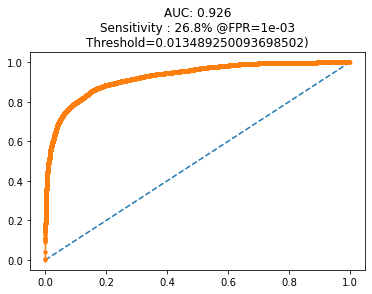

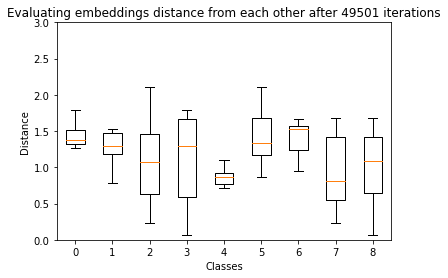

FileMetadata(name='training_curve.png', id='id:5mmeH8mJUyAAAAAAAAACcw', client_modified=datetime.datetime(2020, 8, 25, 22, 16, 23), server_modified=datetime.datetime(2020, 8, 25, 22, 16, 23), rev='015adbb0dacbcaf00000001b45de3f0', size=69165, path_lower='/training_curve.png', path_display='/training_curve.png', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='81f44afe0ac1681ad101f142091f2cdcc9f7cd1177f9d80f5f20d709d7b5e4b1', file_lock_info=None)
FileMetadata(name='history.gz', id='id:5mmeH8mJUyAAAAAAAAACdA', client_modified=datetime.datetime(2020, 8, 25, 22, 16, 24), server_modified=datetime.datetime(2020, 8, 25, 22, 16, 24), rev='015adbb0dc047bc00000001b45de3f0', size=918, path_lower='/history.gz', path_display='/history.gz', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_inf

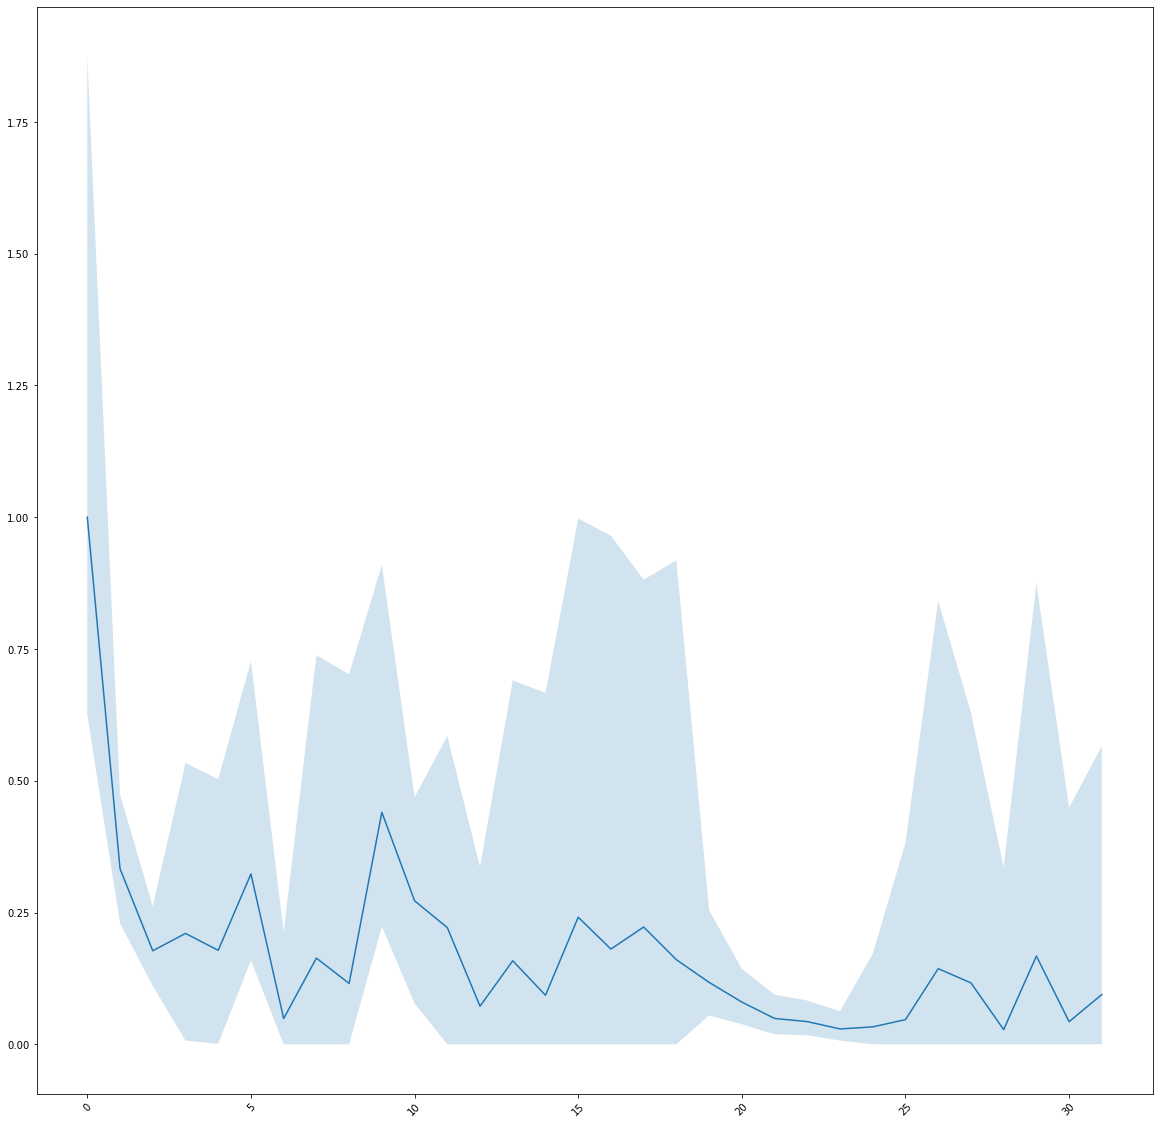

FileMetadata(name='colors_mobilenet_aug_9.h5', id='id:5mmeH8mJUyAAAAAAAAAChg', client_modified=datetime.datetime(2020, 8, 25, 22, 16, 26), server_modified=datetime.datetime(2020, 8, 25, 22, 16, 26), rev='015adbb0ddfa98000000001b45de3f0', size=919024, path_lower='/colors_mobilenet_aug_9.h5', path_display='/colors_mobilenet_aug_9.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='88c3f3d634c692210ede0f6669b396dacb5b29b99e70d7d007188862148f4c5f', file_lock_info=None)


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/functional.py:789: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  UserWarning,


KeyboardInterrupt: 

In [32]:
print("Starting training process!")
file = "history.gz"
# update dataset
dataset_aug = np.array(update_aug(dataset_train, augmentation, verbose=False))
# precalculate embeddings for each image
metrics = network.predict(np.concatenate(dataset_aug, axis=0), batch_size=512
                         ).reshape(*dataset_aug.shape[:2], embeddingsize)
# set evaluation steps
evaluate_every = 500
# set current iteration and total iterations
n_iteration, n_iter = 45651+0*evaluate_every, 90000
# name of network
upload_filename = "colors_mobilenet" 

print("-------------------------------------")
t_start = time.time() - int(0.0*60)

# parameters needed for cycle-learning rate scheduling
uplr = 1.5e-3
llr = 5e-6
factor = 1.0

history = list(np.array(joblib.load(file))) if os.path.exists(file) else [(100., 60., 160.)]
print(history)
best_avg_loss = 100.5
best_auc = 0.946

losses=[]
# change momentum and learning rate in antiphase
clr = np.concatenate([np.linspace(0, uplr-llr, 500), np.linspace(uplr-llr, 0, 500)])
cm = np.concatenate([np.linspace(0.9-0.66, 0, 500), np.linspace(0, 0.9-0.66, 500)])

# use progress bar
pbar = tqdm(total=n_iter+1-n_iteration)

for i in range(n_iteration, n_iter+1):
    # please note, that final batch size will be 3 times larger due to the siamese architecture
    if i < 35000:
        triplets = get_batch_random(256, s='train_aug', aug=False)
    elif i < 55000:
        triplets = get_batch_hard(4096*4, 256, 256, network, s='train_aug', aug=False)
    else:
        triplets = get_batch_hard(4096*2, 256, 256, network, s='train_aug', aug=False)
    loss = network_train.train_on_batch(triplets, None)
    # update progress bar
    pbar.update(1)
    gc.collect()
    n_iteration += 1
    # update lr and momentum
    K.set_value(network_train.optimizer.lr, llr + clr[i%1000]*factor)
    K.set_value(network_train.optimizer.momentum, 0.66 + cm[i%1000])    
    losses.append(loss)
    # augment data every 50 iterations. its a tradeoff between learning without augmentation at all
    # and updating dataset every iteration. Embeddings for triplet mining are recalculated here.
    if i % 50 == 0:
        del dataset_aug
        for _ in range(10):
            gc.collect()
            time.sleep(1)
        dataset_aug = np.array(update_aug(dataset_train, augmentation, verbose=False))
        metrics = network.predict(np.concatenate(dataset_aug, axis=0), batch_size=512
                                 ).reshape(*dataset_aug.shape[:2], embeddingsize)
    # change learning rate upper bound every 1k iterations
    if i % 1000 == 0:
        condition = n_iteration//1000 
        if condition > 80:
            factor=0.1
        elif condition > 50:
            factor=0.05
        elif condition > 25:
            factor=0.5
    # plot learning progress and save best and current weights
    if i % evaluate_every == 0:
        history.append((np.mean(np.array(losses)),
                            np.percentile(np.array(losses), 2.5),
                            np.percentile(np.array(losses), 97.5)))
        print("\n ------------- \n")
        print(f"[{i}] Time for {i} iterations: "
                  f"{int(time.time() - t_start) / 60.0} mins, "
                  f"Train Loss: {history[-1]}")
        probs,yprob = compute_probs(network,x_test_origin,y_test_origin)
        fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
        draw_roc(fpr, tpr, thresholds, auc)
        draw_interdist(network,n_iteration)
        losses = []
        plot_history(history)
        if history[-1][0] < best_avg_loss:
            best_avg_loss = history[-1][0]
            network.save(f'{upload_filename}_aug_best.h5')
        if auc > best_auc:
            best_auc = auc
            network.save(f'{upload_filename}_aug_best_auc.h5')
        network.save(f'{upload_filename}_aug_{i//evaluate_every%10}.h5')
pbar.close()

### 11. Load best model during training

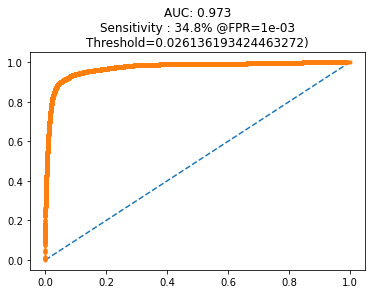

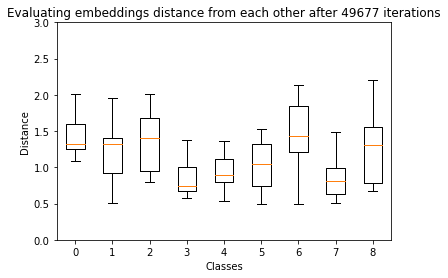

In [38]:
network.load_weights("colors_mobilenet_aug_best.h5")
probs,yprob = compute_probs(network, x_test_origin,
                            y_test_origin)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds, auc)
draw_interdist(network,n_iteration)

### 12. Convert trained keras model to tf-lite model

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(network)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('colors_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

In [40]:
class WrapperTFLite:
    '''Class implementing a wrapper for tf-lite models so it can be used with 
    usual keras.Model's methods.

    Attributes:
        interpreter (tensorflow.lite.Interpreter obj): interpreter for the model.
        input_details (dict): properties about an input image, including it's shape and dtype.
        output_details (dict): properties about an output, including it's shape and dtype.
        
    '''
    __slots__ = ['interpreter', 'input_details', 'output_details']
    def __init__(self, path):
        '''Constructor of tf-lite wrapper class. In constructor you have to define a path
        to the tf lite model

            Args:
                path (str): path to a tensorflow lite model.

        '''
        self.interpreter = tf.lite.Interpreter(path)
        self.interpreter.allocate_tensors()
        # obtaining the input-output shapes and types
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def predict(self, data):
        '''Convinient method to use trained model over all data 
        (tensorflow lite models can predict only one image per time).

            Args:
                data (numpy.ndarray): array as input for the model.

            Returns:
                predictions (numpy.ndarray): model's output array.

        '''
        prediction = []
        # use tqdm for progress bar
        for i in tqdm(range(data.shape[0])):
            # resize input image so it corresponds to the input shape
            img = np.array(Image.fromarray(data[i]).resize(self.input_details[0]['shape'][1:-1], Image.BICUBIC))
            self.interpreter.set_tensor(self.input_details[0]['index'], img.reshape(1, *img.shape)[:,:,:,::-1])
            # running inference
            self.interpreter.invoke()
            # get result and append to prediction list
            prediction.extend(self.interpreter.get_tensor(self.output_details[0]['index']))
        return np.array(prediction)

# load trained tf lite model
network_tflite = WrapperTFLite('colors_mobilenet.tflite')
# Compare embeddings produced by keras and tf-lite models
print(network.predict(x_test_origin))
print(network_tflite.predict(x_test_origin))

[[ 2.2360998e-01  2.1801449e-01  4.7362942e-01 ...  1.7247951e-01
  -2.1982017e-01  4.7846547e-01]
 [ 2.7024522e-01  1.7482065e-01  4.4734776e-01 ...  1.4919262e-01
  -2.3049472e-01  4.8266417e-01]
 [ 1.3433251e-01 -4.8990338e-04  1.4623766e-01 ...  1.9817012e-03
  -8.5907054e-01 -1.2083526e-02]
 ...
 [-1.5991053e-01 -5.0247872e-01  2.9600412e-01 ...  2.4978802e-01
   8.0468118e-02  2.3863815e-01]
 [ 7.9022996e-02  1.9430588e-01 -1.3226719e-01 ... -7.4365713e-02
  -4.6102357e-01 -4.2959207e-01]
 [ 8.0201022e-02  1.9385082e-01 -1.3571195e-01 ... -7.5662397e-02
  -4.6144402e-01 -4.2948270e-01]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



[[ 0.22287571  0.22075781  0.47746432 ...  0.17783885 -0.2140167
   0.47838834]
 [ 0.27221665  0.18588458  0.4487331  ...  0.15369144 -0.23209752
   0.47646093]
 [ 0.13937402  0.0012367   0.15974414 ...  0.01566827 -0.8591757
  -0.01760391]
 ...
 [-0.16578813 -0.5019319   0.28856236 ...  0.24384734  0.08845658
   0.2426225 ]
 [ 0.08099017  0.19591816 -0.13548787 ... -0.07633858 -0.46456486
  -0.43038666]
 [ 0.0872535   0.1992833  -0.13632657 ... -0.07693867 -0.46168667
  -0.42898688]]


### 13. Compare AUC-score of optimised network

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


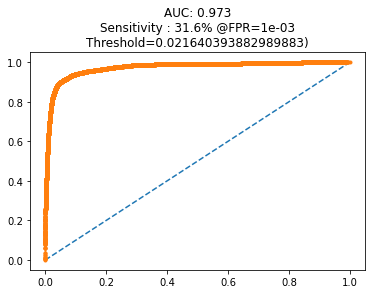

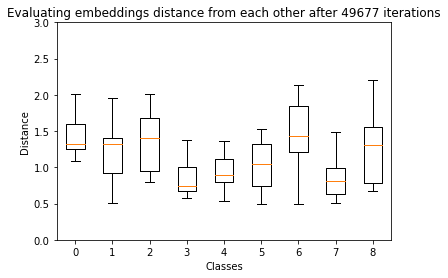

In [41]:
probs,yprob = compute_probs(network_tflite, x_test_origin,
                            y_test_origin)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds, auc)
draw_interdist(network,n_iteration)